In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

C:\Users\Derrick\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [3]:
data = os.path.join('datasets', '10yr_bond_yld.csv')

df = pd.read_csv(data, parse_dates=[0], index_col=0, squeeze=True).dropna()


df.head(-1)

US_10Y  PH_10Y
2001-01-31   5.112  16.289
2001-02-28   4.904  14.893
2001-03-30   4.911  14.661
2001-04-30   5.336  15.750
2001-05-31   5.379  15.021
...            ...     ...
2020-07-31   0.536   2.690
2020-08-31   0.693   2.755
2020-09-30   0.677   3.000
2020-10-30   0.859   3.028
2020-11-30   0.842   3.047

[239 rows x 2 columns]

C:\Users\Derrick\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


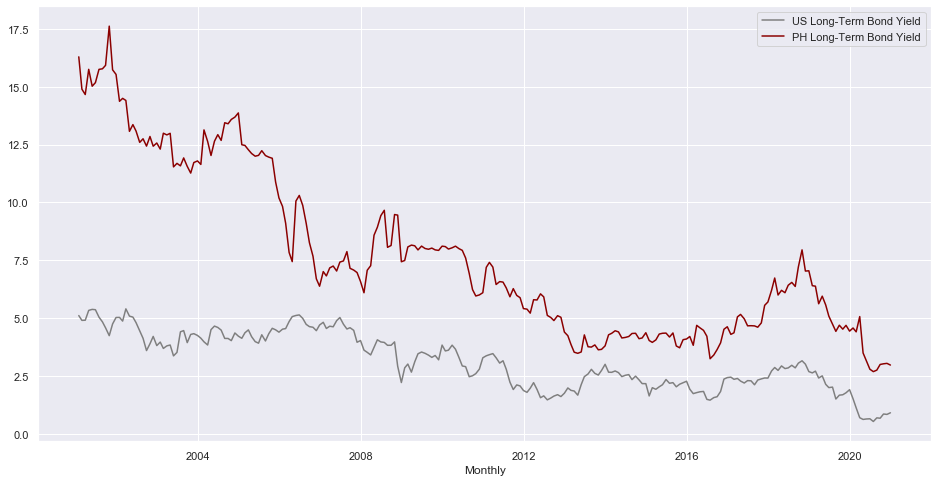

In [5]:
sns.set(style="darkgrid")

fig = plt.figure(figsize=(16,8))

plt.plot(df.US_10Y, color='tab:blue', label='US Long-Term Bond Yield')
plt.plot(df.PH_10Y, color='darkred', label='PH Long-Term Bond Yield')
#plt.title('')
plt.legend()
plt.xlabel('Monthly')

plt.show()

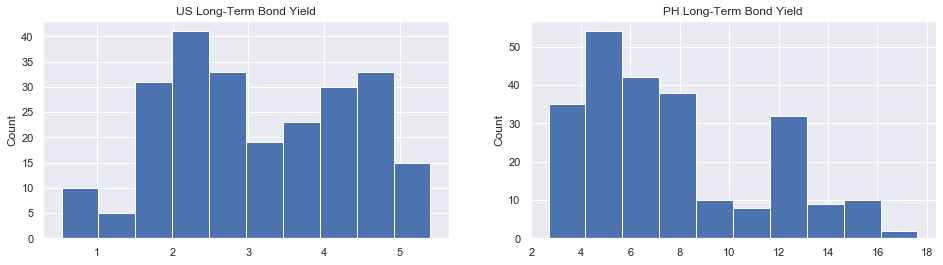

In [6]:
def normal_plots():
    fig = plt.figure(figsize=(16,4))

    plt.subplot(1,2,1)
    plt.hist(df.US_10Y)
    plt.title('US Long-Term Bond Yield')
    plt.ylabel('Count')

    plt.subplot(1,2,2)
    plt.hist(df.PH_10Y)
    plt.title('PH Long-Term Bond Yield')
    plt.ylabel('Count')
    
    plt.show()

normal_plots()

In [7]:
#testing for stationarity
def adf_test(series, name=None, num=None):
    result = adfuller(series)
    if name == None:
        name = str(series.name)
    if num != None:
        name = 'Series %s' % str(num)
    print('\n%s:' %name)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

us_yld = df.US_10Y
ph_yld = df.PH_10Y

adf_test(us_yld)
print('Sample size: %s' %len(us_yld))
adf_test(ph_yld)
print('Sample size: %s' %len(ph_yld))



US_10Y:
ADF Statistic: -1.621359
p-value: 0.472017
Sample size: 240

PH_10Y:
ADF Statistic: -2.041223
p-value: 0.268796
Sample size: 240


In [8]:
# The following code consolidates transofrmation steps into one (and backtracks transformations)
def normalize(series):
    ave, stdev = series.mean(), series.std()
    series = (series-ave)/stdev
    return series

def annual_vol(series):
    stdevs = series.groupby(series.index.year).std()
    return series.index.map(lambda d: stdevs.loc[d.year])

def variance_correct(series):
    return series/annual_vol(series)

def qtr_mean(series):
    means = series.groupby(series.index.month).mean()
    return series.index.map(lambda d: means.loc[d.month])

def seasonality_correct(series):
    return series - qtr_mean(series)

def make_stationary(*data, plot=False, headers=True):
    stdata = []
    for d in data:
        if headers == True:
            header = d.name
        d = normalize(d)
        d = d.diff().fillna(method="bfill")
        d = variance_correct(d)
        #d = seasonality_correct(d).fillna(method="bfill")
        d.name = header
        stdata.append(d)
        
    if len(stdata) == 1:
        return stdata[0]
    else:
        return stdata

In [10]:
series = make_stationary(us_yld, ph_yld)

st_us_yld= series[0]
st_ph_yld = series[1].fillna(method='ffill')


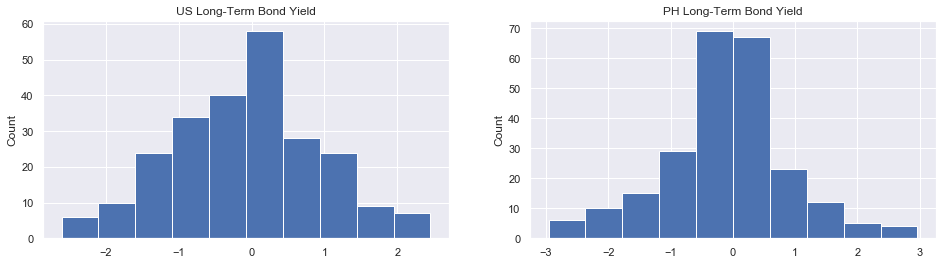

In [11]:
def normal_plots():
    fig = plt.figure(figsize=(16,4))

    plt.subplot(1,2,1)
    plt.hist(st_us_yld)
    plt.title('US Long-Term Bond Yield')
    plt.ylabel('Count')

    plt.subplot(1,2,2)
    plt.hist(st_ph_yld)
    plt.title('PH Long-Term Bond Yield')
    plt.ylabel('Count')
    
    plt.show()

normal_plots()


US_10Y:
ADF Statistic: -14.777355
p-value: 0.000000
Sample size: 240

PH_10Y:
ADF Statistic: -15.158867
p-value: 0.000000
Sample size: 240


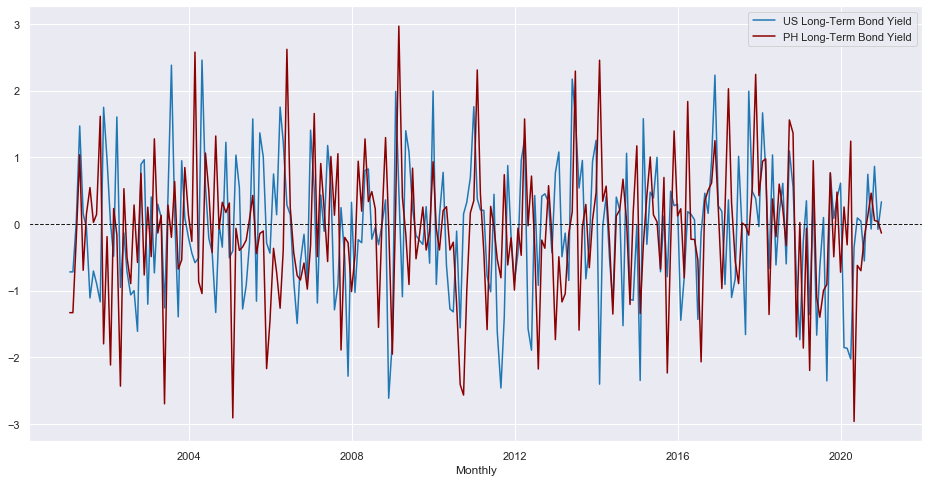

In [22]:
adf_test(st_us_yld)
print('Sample size: %s' %len(st_us_yld))
adf_test(st_ph_yld)
print('Sample size: %s' %len(st_ph_yld))

fig = plt.figure(figsize=(16,8))

plt.plot(st_us_yld, color='tab:blue', label='US Long-Term Bond Yield')
plt.plot(st_ph_yld, color='darkred', label='PH Long-Term Bond Yield')
#plt.title('')
plt.legend()
plt.xlabel('Monthly')
plt.axhline(linewidth=1, linestyle='dashed', color='k')

plt.show()

### Testing Causality

In [15]:
def granger(s1, s2, lag=12):
    granger_df = pd.concat([s1, s2], axis=1).dropna()
    grangercausalitytests(granger_df, lag)

print('Testing causality of US 10 YR -> PH 10 YR\n')
granger(st_ph_yld,st_us_yld)


Testing causality of US 10 YR -> PH 10 YR


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.5978  , p=0.0063  , df_denom=236, df_num=1
ssr based chi2 test:   chi2=7.6944  , p=0.0055  , df=1
likelihood ratio test: chi2=7.5732  , p=0.0059  , df=1
parameter F test:         F=7.5978  , p=0.0063  , df_denom=236, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.7980  , p=0.0238  , df_denom=233, df_num=2
ssr based chi2 test:   chi2=7.7590  , p=0.0207  , df=2
likelihood ratio test: chi2=7.6353  , p=0.0220  , df=2
parameter F test:         F=3.7980  , p=0.0238  , df_denom=233, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.1847  , p=0.0246  , df_denom=230, df_num=3
ssr based chi2 test:   chi2=9.8448  , p=0.0199  , df=3
likelihood ratio test: chi2=9.6458  , p=0.0218  , df=3
parameter F test:         F=3.1847  , p=0.0246  , df_denom=230, df_num=3

Granger Causality
number of lags (no zero) 4
ssr b

***Correlation at lag = 0***

In [16]:
pearsonr(st_us_yld, st_ph_yld)

(0.19342792267330428, 0.0026176428530139454)

No handles with labels found to put in legend.


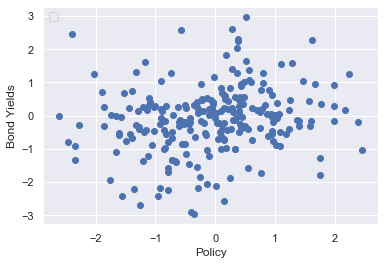

In [17]:
plt.scatter(st_us_yld, st_ph_yld)
plt.xlabel("Policy")
plt.ylabel("Bond Yields")
plt.legend(loc='upper left')
plt.show()

### Shows weak correlation

In [14]:
# Checking average difference of two time series
error = st_bonds - st_policy

np.mean(error)

0.034678547339472114

In [19]:
def create_df(*series):
    df = pd.concat(series, axis=1).dropna()
    n = []
    for i in series:
        n.append(i.name)
    df.columns = n
    return df

corr_df = create_df(st_us_yld, st_ph_yld)



### Fitting VAR Model

In [20]:
### AUTOMATE MODEL SELECTION
def fit_tsmodel(data, model='VAR', lags=4):
    models = ['VAR','SARIMAX']

    if model in models:
        if model == models[0]:
            model = VAR
        elif model == models[1]:
            model == SARIMAX
    else:
        print('Model not supported')
        return None
    
    fmodel = model(data)          
    res = fmodel.fit(maxlags=lags)
    return res

In [21]:
fdf = create_df(st_us_yld, st_ph_yld)
res = fit_tsmodel(fdf,lags=12)
res.summary()

C:\Users\Derrick\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency BM will be used.
  % freq, ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 11, Jan, 2021
Time:                     23:27:56
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   0.945961
Nobs:                     228.000    HQIC:                  0.497341
Log likelihood:          -619.142    FPE:                    1.21614
AIC:                     0.193912    Det(Omega_mle):        0.987671
--------------------------------------------------------------------
Results for equation US_10Y
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const             -0.098685         0.073639           -1.340           0.180
L1.US_10Y          0.055504         0.071695            0.774           0.439
L1.PH_10Y         -0.135008         0.072705           -1.857          

In [23]:
r2_score(res.fittedvalues['PH_10Y']+res.resid['PH_10Y'],
  res.fittedvalues['PH_10Y'])

0.11152977625483806

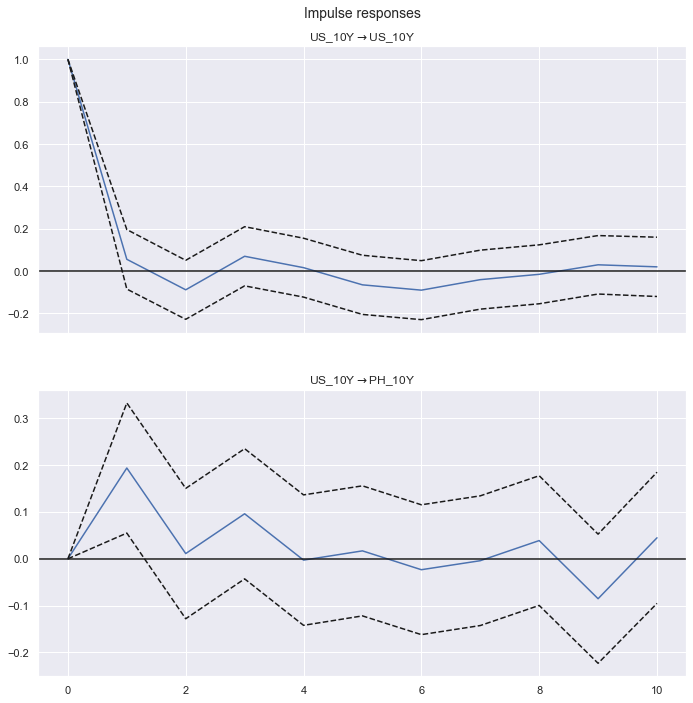

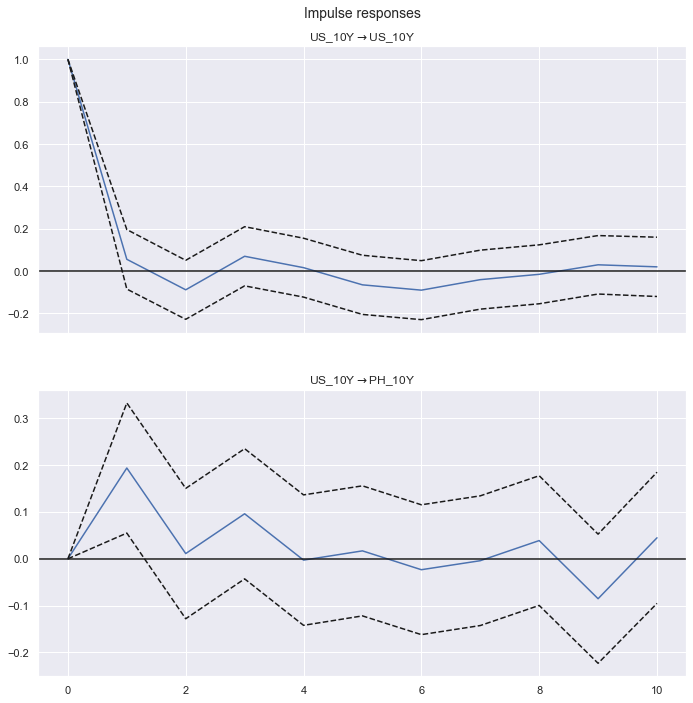

In [24]:
irf = res.irf(10)
irf.plot(orth=False, impulse='US_10Y', response='PH_10Y')